In [1]:
%matplotlib inline
import numpy as np
from scipy import signal
from scipy.misc import imread, imsave, face
from scipy.fftpack import fft2, ifft2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def upsample(img, n):
    # размеры в n раз больше
    new_shape = tuple(map(lambda x: x * n, img.shape))
    
    new_img = np.empty(new_shape)
    for i in xrange(img.shape[0]):
        for j in xrange(img.shape[1]):
            new_img[i*n:(i+1)*n, j*n:(j+1)*n] = np.full((n, n), img[i, j])
    return new_img

In [3]:
def deconv2(c, b):
    Nout = c.shape[0] - b.shape[0] + 1
    Mout = c.shape[1] - b.shape[1] + 1
    b = np.pad(b, [(0, c.shape[0] - b.shape[0]), (0, c.shape[1] - b.shape[1])], "constant", constant_values=0)
    
    a = ifft2(fft2(c) / fft2(b))
    a = np.real(a[:Nout, :Mout])
    return a

Загружаем картинку

In [4]:
src = face(gray=True)

Вводим функцию скользящего окна (PSF)

In [5]:
n = 23
psf = np.ones((n, n)) / n ** 2

Дополним нулями на $2*(n/2)$ с каждой стороны. $n/2$ с каждой стороны съест мой сэмплинг. Еще $n/2$ - развертка.

In [6]:
src = np.pad(src, [(2*(n/2), 2*(n/2)), (2*(n/2), 2*(n/2))], "constant", constant_values=0)

In [7]:
conv = signal.convolve2d(src, psf)

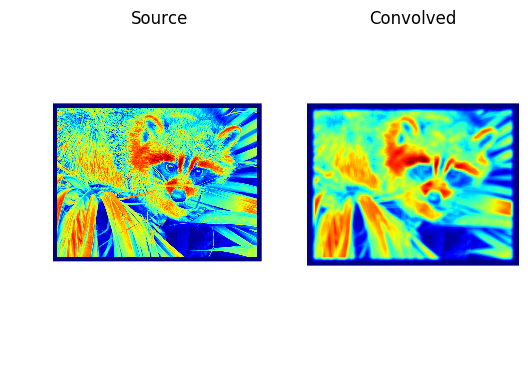

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].imshow(src)
ax[0].axis('off')
ax[0].set_title('Source')

ax[1].imshow(conv)
ax[1].axis('off')
ax[1].set_title('Convolved')

plt.show()

Разворачиваем и сравниваем с исходным изображением

In [9]:
enh = deconv2(conv, psf)

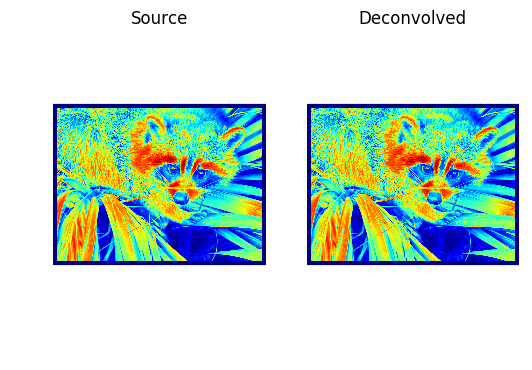

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].imshow(src)
ax[0].axis('off')
ax[0].set_title('Source')

ax[1].imshow(enh)
ax[1].axis('off')
ax[1].set_title('Deconvolved')

plt.show()

Сгенерим картинки, будто бы от наших механических сдвигов. Мы хотим получить то же, что и в результате свертки.

Border - это граница, на которой у нас нет данных.

In [11]:
h, w = src.shape
bh, bw = psf.shape[0] / 2, psf.shape[1] / 2

print "height:", h, "width:", w
print "border_height:", bh, "border_width:", bw

height: 812 width: 1068
border_height: 11 border_width: 11


In [12]:
sample_h, sample_w = h / n, w / n
sample_imgs = np.empty((psf.shape[0], psf.shape[1], sample_h, sample_w))

print "h:", h, "w:", w, "n:", n
def generate_sample_images():
    # hs, ws обозначают сдвиг, с которого мы начинаем прикладывать шаблон
    for hs in xrange(sample_imgs.shape[0]):
        for ws in xrange(sample_imgs.shape[1]):
            tmp = np.zeros((sample_h, sample_w))
            # i, j - left upper corner of template
            
            for i in xrange(hs, h - n + 1, n):
                for j in xrange(ws, w - n + 1, n):
#                     print i, j, i / n, j / n
                    tmp[i / n, j / n] = np.sum(src[i:i+n, j:j+n] * psf)
            sample_imgs[hs, ws] = tmp
                     

h: 812 w: 1068 n: 23


In [13]:
generate_sample_images()    

Сопоставим графики

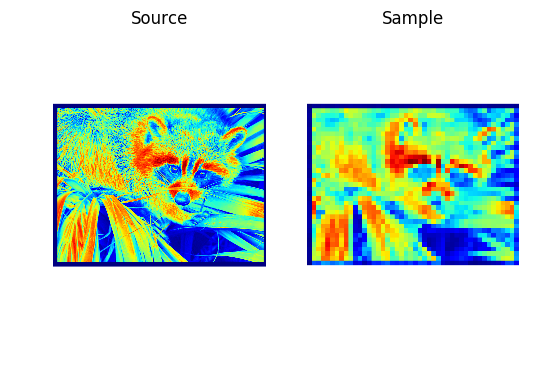

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].imshow(src)
ax[0].axis('off')
ax[0].set_title('Source')

ax[1].imshow(upsample(sample_imgs[0, 0], n))
ax[1].axis('off')
ax[1].set_title('Sample')

plt.show()

Составим из множества картинок со сдвигами одну, которая будет выглядеть как свернутая с PFS

In [15]:
sampled = np.empty((h - 2*bh, w - 2*bw))

for hs in xrange(sample_imgs.shape[0]):
    for ws in xrange(sample_imgs.shape[1]):
        for i in xrange(hs, h - n + 1, n):
            for j in xrange(ws, w - n + 1, n):
                # i, j - левый верхний угол шаблона, но мы как раз сдвигаем на полшаблона
                sampled[i, j] = sample_imgs[hs, ws, i/n, j/n]

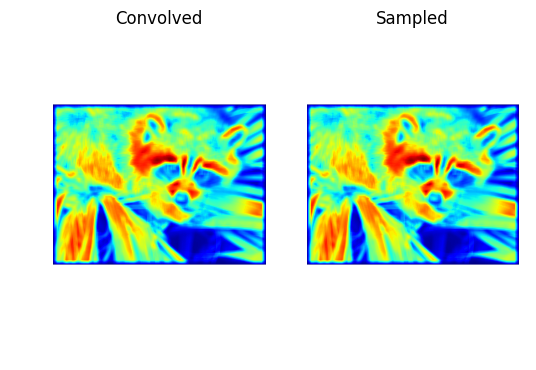

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].imshow(conv[2*bh:-2*bh,2*bw:-2*bw])
ax[0].axis('off')
ax[0].set_title('Convolved')

ax[1].imshow(sampled)
ax[1].axis('off')
ax[1].set_title('Sampled')

plt.show()

Развернем и сравним с исходной

In [18]:
deconved = deconv2(sampled, psf)

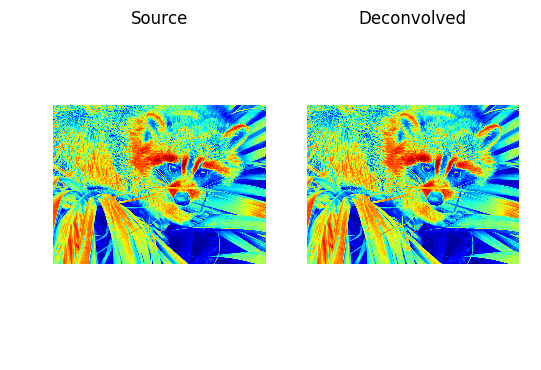

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)

ax[0].imshow(src[2*bh:-2*bh,2*bw:-2*bw])
ax[0].axis('off')
ax[0].set_title('Source')

ax[1].imshow(deconved)
ax[1].axis('off')
ax[1].set_title('Deconvolved')

plt.show()